Author: Micheal C. Chen

Email: muchuchen03@gmail.com

# Task 1
In this task, we will infinite Time Evolve Block Decimation (iTEBD) algorithm to solve a 1D **Cluster-Ising** chain with open boundary condition (OBC):
$$
H = \sum_j \left[-\left(X_j + Z_j Z_{j+1}\right) + g\left(X_jZ_{j+1}Z_{j+2}+Z_jZ_{j+1}X_{j+2}\right)\right]
$$
where $X,Y,Z$ denote Pauli $X,Y,Z$ matrices.
* For single-body terms, $j=1,\ldots, N$
* For two-body terms, $(j, j +1) = (1, 2), (2, 3),\ldots, (N-1, N)$
* For three-body terms, $(j, j+1, j+2) = (1, 2, 3), (2, 3, 4), \ldots, (N-2, N-1, N)$

Use the parameters:  $Ds =6$, $g = 0.428$.

## Tasks
1. Write 3-site iTEBD algorithm to calculate ground state energt $E$ per site and magnetization per site $\langle Z_i\rangle$ and $\langle X_i\rangle$.
2. Calculate entanglement entropy $S = -\sum_\alpha \lambda_\alpha ^ 2 \ln \lambda_\alpha ^ 2 $ and entanglement spectrum $-\ln \lambda_\alpha$.

In [41]:
import numpy as np
import numpy.linalg as LA
import Sub180221 as sub

We firstly define Pauli matrices: $I$,$X$,$Y$,$Z$. And write Hamiltonian to 3 different form:
$$
H = \sum_{j\mod 3 = 0} h_{j, j+1, j+2} + \sum_{j\mod 3 = 1} h_{j, j+1, j+2} + \sum_{j\mod 3 = 2} h_{j, j+1, j+2}
$$

Then we build each local Hamiltonian $h_j$

In [42]:
def GenPauliOp():
    """
    Return four Pauli matrices I, X, Y, Z.
    """
    I = np.array([[1, 0], [0, 1]], dtype = complex)
    X = np.array([[0, 1], [1, 0]], dtype = complex)
    Y = np.array([[0, -1j],[1j, 0]], dtype = complex)
    Z = np.array([[1, 0], [0, -1]], dtype = complex)
    return I, X, Y, Z

def LocalHam(g):
    I, X, Y, Z = GenPauliOp()
    HamExternal = -1/3 * (np.kron(np.kron(X, I), I) +np.kron(np.kron(I, X), I) +np.kron(np.kron(I, I), X))
    HamIsing = -1/2 * (np.kron(np.kron(Z, Z), I) +np.kron(np.kron(I, Z), Z))
    HamCluster = g * (np.kron(np.kron(X, Z), Z) +np.kron(np.kron(Z, Z), X))
    Ham = HamExternal + HamIsing + HamCluster
    return Ham


Then we use Trotter-Suzuki decomposition to the first order:
$$
U = \prod_{M\to \infty}U(\delta \tau) = \prod_{M\to \infty} \left[ \prod_{j \mod 3 = 0}U_{j, j+1, j+2}(\delta \tau)\right]\left[ \prod_{j \mod 3 = 1}U_{j, j+1, j+2}(\delta \tau)\right]\left[ \prod_{j \mod 3 = 2}U_{j, j+1, j+2}(\delta \tau)\right]
$$

And solve each local unitary $U_{j, j+1, j+2}$

In [43]:
def LocalEvoOper(Ham, time, Dp = 2):
    Ham = Ham.astype(complex, copy=False)
    eigval, eigvec = LA.eigh(Ham)
    evo_coeff = np.exp(-time * eigval)
    uH = eigvec @ np.diag(evo_coeff) @ eigvec.conj().T
    uH = np.reshape(uH, (Dp, Dp, Dp, Dp, Dp, Dp))
    return uH

In [44]:
def InitiMPS(Dp, Ds):
    GTensor = [None] * 3
    TTensor = [None] * 3
    for site in range(3):
        TTensor[site] = np.random.rand(Ds, Dp, Ds) + 1j * np.random.rand(Ds, Dp, Ds)
        GTensor[site] = np.random.rand(Ds) + 1j * np.random.rand(Ds)
    return GTensor, TTensor

In [45]:
def EvoBond(Gl, Tl, Gml, Tm, Gmr, Tr, Gr, uH, Ds):
    Tensor = sub.NCon([np.diag(Gl), Tl, np.diag(Gml), Tm, np.diag(Gmr), Tr, np.diag(Gr), uH],
                       [[-1, 1], [1, 7, 2], [2, 3], [3, 8, 4], [4, 5], [5, 9, 6], [6, -5], [-2, -3, -4, 7, 8, 9]])
    DT = np.shape(Tensor)
    Dl, d1, d2, d3, Dr = DT
    # First SVD decomposition
    Mat = sub.Group(Tensor, [[0, 1], [2, 3, 4]])
    U1, S1, V = LA.svd(Mat, full_matrices=False)
    DcL = min(np.shape(U1)[1], Ds)
    U1 = U1[:, :DcL]; Gml = S1[:DcL]; Vh = V[:DcL, :]
    Gml /= np.sqrt(np.sum(Gml**2))

    Vh = np.tensordot(np.diag(Gml), Vh, (1, 0))
    U1 = np.reshape(U1, (Dl, d1, DcL))
    Tl = np.tensordot(np.diag(1/Gl), U1, (1, 0))

    # Second SVD decomposition
    Vh = np.reshape(Vh, (DcL, d2, d3, Dr))
    Mat = sub.Group(Vh, [[0, 1], [2, 3]])
    U2, S2, V2 = LA.svd(Mat, full_matrices=False)
    DcR = min(np.shape(U2)[1], Ds)
    U2 = U2[:, :DcR]; Gmr = S2[:DcR]; V2 = V2[:DcR, :]
    Gmr /= np.sqrt(np.sum(Gmr**2))

    U2 = np.reshape(U2, (DcL, d2, DcR))
    Tm = np.tensordot(np.diag(1/Gml), U2, (1, 0))
    V2 = np.reshape(V2, (DcR, d3, Dr))
    Tr = np.tensordot(V2, np.diag(1/Gr), (2, 0))

    return Tl, Gml, Tm, Gmr, Tr

In [46]:
def Evo(Iter, Tau, Ham, Ds, Prec):
    Dp = 2
    GTensor, TTensor = InitiMPS(Dp, Ds)
    
    errs = []
    phase_breaks = [0]
    global_sweep = 0

    for idt in range(len(Tau)):
        dt = Tau[idt]
        uH = LocalEvoOper(Ham, dt)

        G0 = np.ones(3, dtype=float)

        for step in range(Iter):
            for idx in range(3):
                Tl_new, Gml_new, Tm_new, Gmr_new, Tr_new = EvoBond(
                    GTensor[(idx-1) % 3],   # Gl
                    TTensor[idx],           # Tl
                    GTensor[idx],           # Gml
                    TTensor[(idx+1) % 3],   # Tm
                    GTensor[(idx+1) % 3],   # Gmr
                    TTensor[(idx+2) % 3],   # Tr
                    GTensor[(idx+2) % 3],   # Gr
                    uH, Ds
                )

                TTensor[idx]              = Tl_new
                GTensor[idx]              = Gml_new
                TTensor[(idx+1) % 3]      = Tm_new
                GTensor[(idx+1) % 3]      = Gmr_new
                TTensor[(idx+2) % 3]      = Tr_new

            curr = np.array([float(GTensor[i][0]) for i in range(3)], dtype=float)
            Err  = float(np.sum(np.abs(curr - G0)))
            global_sweep += 1
            errs.append((global_sweep, Err))

            # if global_sweep % 100 == 1:
            #     # print(global_sweep, Err)

            if Err < float(np.squeeze(Prec[idt])):
                # print(dt, global_sweep, Err)
                break

            G0 = curr

        phase_breaks.append(global_sweep)

    return TTensor, GTensor, errs, phase_breaks

In [47]:
Ds = 6
Dp = 2

Tau = [0.1, 0.01, 0.001]
Iter = 10000
Prec = [1.0e-10]*3
g = 1
Ham = LocalHam(g)
TTensor, GTensor, errs, phase_breaks = Evo(Iter, Tau, Ham, Ds, Prec)

We firstly visualize error with sweeps.

Text(0.5, 1.0, 'Convergence: error vs. sweeps')

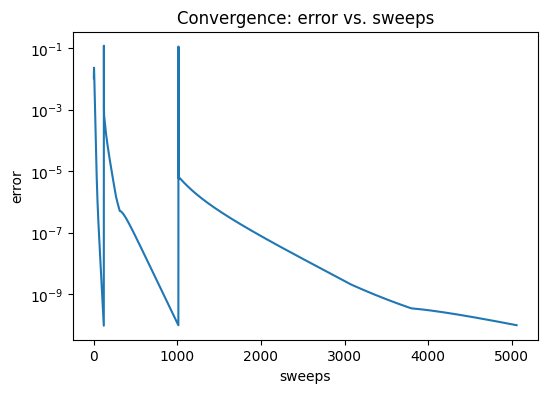

In [74]:
import matplotlib.pyplot as plt

iters = np.array([k for k, _ in errs])
vals  = np.array([e for _, e in errs])

plt.figure(figsize=(6,4))
plt.semilogy(iters, vals)
plt.xlabel("sweeps")
plt.ylabel("error")
plt.title("Convergence: error vs. sweeps")

## Result 1:
Then we calculate **ground state energy** per site using the corresponding tensor graph
<p align="center">
  <img src="CalEnergy.png" alt="Calculate ground state energy" style="width:40%;"">
  
</p>

In [69]:
def CalEnergy(GTensor, TTensor, Ham, Dp = 2):
    Num = len(GTensor)
    energy = []
    for idx in range(Num):
        UpTensor = sub.NCon([np.diag(GTensor[(idx-1)% Num]), TTensor[idx], np.diag(GTensor[idx]), TTensor[(idx+1)% Num], np.diag(GTensor[(idx+1)%Num]),  TTensor[(idx+2)%Num], np.diag(GTensor[(idx+2)%Num])],
                            [[-1, 1], [1, -2, 2], [2, 3], [3, -3, 4], [4, 5], [5, -4, 6], [6, -5]])
        Ham = np.reshape(Ham, (Dp, Dp, Dp, Dp, Dp, Dp))
        DownTensor = sub.NCon([np.diag(GTensor[(idx-1)% Num]), np.conj(TTensor[idx]), np.diag(GTensor[idx]), np.conj(TTensor[(idx+1)% Num]), np.diag(GTensor[(idx+1)%Num]),  np.conj(TTensor[(idx+2)%Num]), np.diag(GTensor[(idx+2)%Num])],
                            [[-1, 1], [1, -2, 2], [2, 3], [3, -3, 4], [4, 5], [5, -4, 6], [6, -5]])
        Val = sub.NCon([UpTensor, Ham, DownTensor], [[7, 1, 2, 3, 8], [4, 5, 6, 1, 2, 3], [7, 4, 5, 6, 8]])
        energy.append(np.real(Val))
    return energy

In [70]:
energy = CalEnergy(GTensor, TTensor, Ham, Dp=2)
print("ground_state_energy_per_site:", np.mean(energy))

ground_state_energy_per_site: -1.2477390533002868


We calculate magnetization per site using thhe tensor graph:
<p align="center">
  <img src="CalMagnetization.png" alt="Calculate magnetization" style="width:20%;"">
  
</p>

In [49]:
def CalMagnet(GTensor, TTensor):
    I, X, _, Z = GenPauliOp()
    # benchmark = []
    Num = len(GTensor)
    PauliX = []
    PauliZ = []
    for idx in range(Num):
        EnvLeft = sub.NCon([np.diag(GTensor[(idx-1)% Num]), np.conj(np.diag(GTensor[(idx-1)% Num]))], [[1, -1], [1, -2]])
        EnvRight = sub.NCon([np.diag(GTensor[idx]), np.conj(np.diag(GTensor[idx]))], [[-1, 1], [-2, 1]])
        # bench = sub.NCon([EnvLeft, TTensor[idx], I, np.conj(TTensor[idx]), EnvRight], [[1, 3], [1, 5, 2], [5, 6], [3, 6, 4], [2, 4]])
        XVal = sub.NCon([EnvLeft, TTensor[idx], X, np.conj(TTensor[idx]), EnvRight], [[1, 3], [1, 5, 2], [5, 6], [3, 6, 4], [2, 4]])
        ZVal = sub.NCon([EnvLeft, TTensor[idx], Z, np.conj(TTensor[idx]), EnvRight], [[1, 3], [1, 5, 2], [5, 6], [3, 6, 4], [2, 4]])
        # benchmark.append(bench)
        PauliX.append(complex(XVal))
        PauliZ.append(complex(ZVal))

    return PauliX, PauliZ

In [52]:
XLst, ZLst = CalMagnet(GTensor, TTensor)
print("sigmax_per_site:", XLst)
print("sigmaz_per_site:", ZLst)
# print("Benchmark:", benchmark)

sigmax_per_site: [(0.7663242466347497+6.357875408501322e-18j), (0.7663299192629276+0j), (0.7662033323872481+3.944304526105059e-31j)]
sigmaz_per_site: [(-5.98965321785272e-14-1.717263563528837e-17j), (-8.909539772616881e-14+2.538401921440904e-31j), (-1.0524914273446484e-13+2.551402870250841e-31j)]


## Result 2：
Finally, we calculate the **entanglement entropy** and **entanglement spectrum** with only GTensor.

In [71]:
def CalEntanglement(GTensor, eps=1e-15):
    EE_per_site = []
    ES_energy = []

    for g in GTensor:
        lam = np.asarray(g, dtype=np.complex128)

        p = np.abs(lam)**2
        Z = np.sum(p)
        p = p / Z

        mask = p > eps
        S = -np.sum(p[mask] * np.log(p[mask]))
        EE_per_site.append(float(S))

        e = -0.5 * np.log(p + eps)
        ES_energy.append(e)

    EE_per_site = np.array(EE_per_site)
    ES_energy = np.vstack(ES_energy)

    return EE_per_site, ES_energy


In [73]:
EE_per_site, ES_energy = CalEntanglement(GTensor)
print("entanglement_entropy_per_site: ", EE_per_site)
print("entanglement_spectrum_energy_per_site:\n", ES_energy)

entanglement_entropy_per_site:  [0.30850706 0.30892417 0.30892419]
entanglement_spectrum_energy_per_site:
 [[0.03917548 1.37737216 2.389807   2.92539298 4.03577772 4.41704344]
 [0.0392439  1.37663169 2.38850838 2.92375606 4.03450487 4.41651993]
 [0.0392439  1.37663164 2.38850852 2.92375588 4.03450494 4.41651963]]
